# Decision Trees

We will implement decision trees for binary classification.

We split a node by measuring the loss of splitting with respect to each possible feature and threshold, and split based on the feature and threshold that minimizes this loss.
Mathematically:
$$X_L = \{x\ :\ x \in X \wedge  x[i] \leq j\}$$
$$X_R = \{x\ :\ x \in X \wedge  x[i] > j\}$$
where $x[i]$ is the $i$-th coordinate of point $x$.
The vector of labels $y$ is split into vectors $y_L$ and $y_R$ using the same indices.

The loss of splitting a training dataset into a left and right half is computed as 
$$
\ell(X,y,i,j) = \frac{|y_L|}{|y|}\ell(y_L) + \frac{|y_R|}{|y|}\ell(y_R) 
$$

We will consider the following loss functions $\ell$, specialized for binary classification. 
Define $\hat p$ for a vector of labels $y$ to be $\frac{|\{y_j = 1 : y_j \in y\}|}{|y|}$, that is, the fraction of labels which are $1$.
We have the following three loss functions.

- Misclassification error:
$$
\min \{\hat p, 1-\hat p\}
$$
- Gini coefficient:
$$\hat p (1 - \hat p)$$
- Entropy:
$$- \hat p \log_2 (\hat p) - (1 - \hat p) \log_2 (1 - \hat p ) $$

We do not split a node if it is pure (i.e., consists entirely of either $0$'s or $1$'s), or if a split would exceed a maximum depth hyperparameter provided to the decision tree (recall that the depth of a single-node tree is $0$).


In [ ]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
import math

In [68]:
class DecisionTree:
    def __init__(self, loss):
        self.dep = None
        self.left, self.right, self.key = None, None, None
        self.split_var = None
        self.threshold = None
        self.loss_func = loss
        self.correct = None
        return

    def build(self, X, Y):
        n, d = X.shape[0], X.shape[1]
        pure = True
        prev_y = Y[0]
        for i in range(1, n):
            if Y[i] != prev_y:
                pure = False
                break
        if not pure:
            x_l, x_r, y_l, y_r = np.array([[]]), np.array([[]]), np.array([]), np.array([])
            min_loss = None
            min_j, min_t = None, None
            # try all variables and threshhold to split on
            for j in range(d):
                for i in range(n):
                    x_ll, x_rr, y_ll, y_rr = np.array([[]]), np.array([[]]), np.array([]), np.array([])
                    t = X[i][j]
                    for k, row in enumerate(X):
                        # print(row.shape)
                        if row[j] <= t: 
                            x_ll = np.concatenate((x_ll, np.array([row])), axis=0) if len(x_ll[0]) > 0 else np.array([row])
                            y_ll = np.append(y_ll, Y[k])
                        else:
                            x_rr = np.concatenate((x_rr, np.array([row])), axis=0) if len(x_rr[0]) > 0 else np.array([row])
                            y_rr = np.append(y_rr, Y[k])
                    # print("left shape {}, right shape {}".format(x_ll.shape, x_rr.shape))
                    loss = (len(y_ll) / n) * self.loss_func(y_ll) if len(y_ll) > 0 else 0
                    loss += (len(y_rr) / n) * self.loss_func(y_rr) if len(y_rr) > 0 else 0
                    if min_loss == None or loss < min_loss: 
                        x_l, x_r, y_l, y_r = x_ll, x_rr, y_ll, y_rr 
                        min_loss = loss
                        min_j, min_t = j, t
            count_0, count_1 = 0,0
            for y in Y:
                if y == 0: count_0 += 1
                else: count_1 += 1
            self.key = 0.0 if count_0 > count_1 else 1.0
            self.correct = count_0 if self.key == 0 else count_1
            if len(y_r) != 0:
                self.left, self.right = DecisionTree(self.loss_func), DecisionTree(self.loss_func)
                self.split_var = min_j
                self.threshold = min_t
                # print("left: {}, right: {}".format(x_l.shape, x_r.shape))
                # print(f"split on {min_j} with t = {min_t}, loss value is {min_loss}")
                self.dep = max(self.left.build(x_l, y_l), self.right.build(x_r, y_r)) + 1
            else:
                self.dep = 0
        else:
            self.key = prev_y
            self.correct = n
            self.dep = 0
        return self.dep
    
    def predict(self, X, depth):
        if depth == 0 or self.dep == 0:
            return self.key
        elif self.dep > 0 and X[self.split_var] <= self.threshold:
            return self.left.predict(X, depth-1)
        elif self.dep > 0 and X[self.split_var] > self.threshold:
            return self.right.predict(X, depth-1)
    
    def get_correct(self, depth):
        if depth == 0 or self.dep == 0:
            return self.correct
        else:
            return self.left.get_correct(depth-1) + self.right.get_correct(depth-1)

def find_p(Y):
    count_0, count_1 = 0,0
    for y in Y:
        if y == 0: count_0 += 1
        else: count_1 += 1
    return count_1 / len(Y)

# Misclassification Error
def misclassification(Y):
    p = find_p(Y)
    return min(p, 1-p)

# Gini Coefficient
def giniCoefficient(Y):
    p = find_p(Y)
    return p * (1-p)

# Entropy
def entropy(Y):
    p = find_p(Y)
    res = -1 * p * math.log(p, 2) if p != 0 else 0
    res -= (1-p) * math.log(1-p, 2) if (1-p) != 0 else 0
    return res

In [69]:
# Load data
X_train = np.loadtxt('datasets/decision_tree data/data/X_train.csv', delimiter=",")
y_train = np.loadtxt('datasets/decision_tree data/data/y_train.csv', delimiter=",").astype(int)
X_test = np.loadtxt('datasets/decision_tree data/data/X_test.csv', delimiter=",")
y_test = np.loadtxt('datasets/decision_tree data/data/y_test.csv', delimiter=",").astype(int)
# print(X_train.shape, y_train.shape)

In [70]:
# Miclassification error Decision Tree
misclassification_tree = DecisionTree(misclassification)
misclassification_tree.build(X_train, y_train)
misclassification_TestAccuracy = np.zeros(misclassification_tree.dep)
misclassification_TrainAccuracy = np.zeros(misclassification_tree.dep)
for d in range(misclassification_tree.dep):
    misclassification_TrainAccuracy[d] = misclassification_tree.get_correct(d) / len(y_train)
    for i, x in enumerate(X_test):
        res = misclassification_tree.predict(x, d)
        misclassification_TestAccuracy[d] += 1 if res == y_test[i] else 0
misclassification_TestAccuracy /= len(X_test)
misclassification_TrainAccuracy *= 100
misclassification_TestAccuracy *= 100

In [71]:
# Gini Coefficient Decision Tree
gini_tree = DecisionTree(giniCoefficient)
gini_tree.build(X_train, y_train)
gini_TestAccuracy = np.zeros(gini_tree.dep)
gini_TrainAccuracy = np.zeros(gini_tree.dep)
for d in range(gini_tree.dep):
    gini_TrainAccuracy[d] = gini_tree.get_correct(d) / len(y_train)
    for i, x in enumerate(X_test):
        res = gini_tree.predict(x, d)
        gini_TestAccuracy[d] += 1 if res == y_test[i] else 0
gini_TestAccuracy /= len(X_test)
gini_TrainAccuracy *= 100
gini_TestAccuracy *= 100

In [72]:
# Entrophy Decision Tree
entrophy_tree = DecisionTree(entropy)
entrophy_tree.build(X_train, y_train)
entrophy_TestAccuracy = np.zeros(entrophy_tree.dep)
entrophy_TrainAccuracy = np.zeros(entrophy_tree.dep)
for d in range(entrophy_tree.dep):
    entrophy_TrainAccuracy[d] = entrophy_tree.get_correct(d) / len(y_train)
    for i, x in enumerate(X_test):
        res = entrophy_tree.predict(x, d)
        entrophy_TestAccuracy[d] += 1 if res == y_test[i] else 0
entrophy_TestAccuracy /= len(X_test)
entrophy_TestAccuracy *= 100
entrophy_TrainAccuracy *= 100

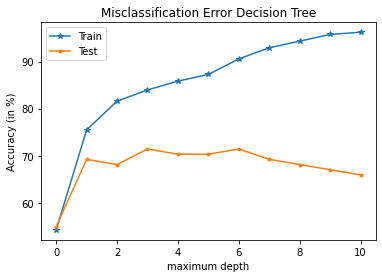

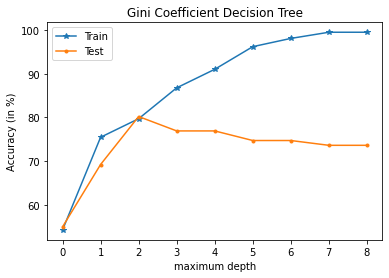

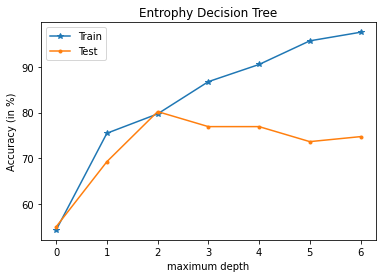

In [73]:
plt.figure(1)
plt.plot(range(misclassification_tree.dep), misclassification_TrainAccuracy, '*-', label="Train")
plt.plot(range(misclassification_tree.dep), misclassification_TestAccuracy, '.-', label="Test")
plt.title("Misclassification Error Decision Tree")
plt.xlabel("maximum depth")
plt.ylabel("Accuracy (in %)")
plt.legend()

plt.figure(2)
plt.plot(range(gini_tree.dep), gini_TrainAccuracy, '*-',  label="Train")
plt.plot(range(gini_tree.dep), gini_TestAccuracy, '.-', label="Test")
plt.title("Gini Coefficient Decision Tree")
plt.xlabel("maximum depth")
plt.ylabel("Accuracy (in %)")
plt.legend()

plt.figure(3)
plt.plot(range(entrophy_tree.dep), entrophy_TrainAccuracy, '*-', label="Train")
plt.plot(range(entrophy_tree.dep), entrophy_TestAccuracy, '.-', label="Test")
plt.title("Entrophy Decision Tree")
plt.xlabel("maximum depth")
plt.ylabel("Accuracy (in %)")
plt.legend()

We can see that the Entrophy decision tree has the best testing accuracy with the smallest depth of the decision tree among all three loss function, so it performs the best. The Misclassification decision tree has the worst testing accuracy with the largest depth of the decision tree, so it performs the worst. As the maximum depth increases, the training accuracy increases because we divide the training sets into more subsets, so the number of correct labels it predicts increase. It is reasonable to see the training set accuracy reaches about 100% at the end. The testing accuracy reaches its maximum at around 2 or 3, and gradually decreases afterwards. This is because at about level 2 or 3, the decision tree only has the general pattern of the training set and thus could be right when applying to the testing set. But once we go deeper, the decision tree includes more details of the training set, which could be very different from the testing set, so the number of correct labels we predict decreases. 

Overall, we have the testing set accuracy above 50% for all cases, so we conclude that the features of the decision tree are correctly labeled.